In [1]:
import os, sklearn, pandas, numpy as np
from sklearn import svm
import skimage, skimage.io, skimage.filters
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
import keras
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Reshape, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model

Using TensorFlow backend.


In [3]:
# custom scripts
import config # params, constants
import data, models # functions that mutate outr data
from utils import utils, plot # custom functions, in local environment

 Dataset :: namedtuple(
    ['train' = ['img_name']
    , 'test' = ['img_name']
    , 'labels' = pandas.df('img_name','breed')
    , 'dict_index_to_label' = dict to convert label_index -> label_name
    , 'dict_label_to_index'= dict to convert label_name -> label_index
    


# Prepare dataset
amt should be either 50, 100, 150, 200 etc...

In [4]:
# some img mutation functions

def replace(v1,v2):
    return v2

def add(v1,v2):
    # mean of r,g,b
    return np.mean([v1,v2] ,axis=0)
    # return v1 + np.minimum(v1, v2) / 2

def overlay(v1,v2):
    # add smallest element values
    intermediate = np.minimum(v1, v2)
    return v1 + intermediate # np.minimum(v1,v2)

In [5]:
def random_colored(dims=50):
    img = np.random.random([dims,dims,3])
    # reduce the 'complexity'
    img /= 10
    # increase the bias (per image)
    brightness = 1.5
    color_mutation = np.random.random(3) * brightness
    img *= [[color_mutation for _ in range(dims)] for _ in range(dims)]
    #         img *= [ np.random.random([3]) for _ in range(dims)]
    # brightness
    img *= np.random.random()
    # scale back
    img *= 10
    img = np.clip(img,0,1)
    return img


def random_pos(img):
    # random (x,y) in image
    return np.random.random([2]) * img.shape[0:2]


def add_random(img,f,dims=50):
    # function to mutate an image by adding a small matrix with noise
    # f() can be add/minimum/maximum
    size = 10 
    size = 1 + int(dims * np.random.random() ** 2)
    (x,y) = random_pos(img)
    x = int(round(x))
    y = int(round(y))
    xs = np.clip(np.arange(x,x + size), 0, dims - 1)
    ys = np.clip(np.arange(y,y + size), 0, dims - 1)
    img_ = random_colored(size)
    for i,x in enumerate(xs): 
        for j,y in enumerate(ys):
            img[x,y] = f(img[x,y],img_[i,j])
    return img

 
def random(amt=10,dims=50):
    result = []
    for _ in range(amt):
        img = random_colored(dims)
        for _ in range(np.random.randint(0,10)):
           img = add_random(img,add,dims)
        result.append(img)
    return np.stack(result)

In [6]:
amt = 30
dims = 50
# x_train = np.random.random([amt,dims,dims,3])
x_train = random(amt,dims)
x_test = np.random.random([amt,dims,dims,3])
y_train = [int((np.random.random() * 9) ) for _ in range(amt)]
# y_train = [ int(x_train[i].mean() * 10) for i in range(x_train.shape[0]) ]
y_test = [int((np.random.random() * 9) ) for _ in range(amt)]

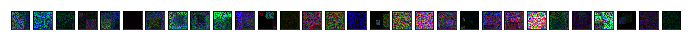

In [7]:
plot.multiple(x_train)

### Prepare the labels

Encode the labels to one-hot vectors

In [8]:
# int-labels => one-hot vectors
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('n labels:',y_train[0].shape)
print(y_train.shape)
y_train[0]

n labels: (8,)
(30, 8)


array([1., 0., 0., 0., 0., 0., 0., 0.])

# Train a Sequential model (keras)

In [9]:
n_samples = x_train.shape[0] # = length of the list of images (matrices)
input_shape = x_train.shape[1:] # = shape of an individual image (matrix)
output_length = (y_train[0]).shape[0] # = length of an individual label
print('n samples:',n_samples)
print('shape:', input_shape)
print('output length:', output_length)

n samples: 30
shape: (50, 50, 3)
output length: 8


## Setup encoders

In [10]:
print(input_shape)
hidden_size = 2 # 2

input_ = Input(shape=input_shape)

x = Conv2D(4, (3, 3), activation='relu', padding='same', input_shape=input_shape)(input_)
# 1/2
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (4, 4), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
x = Dense(hidden_size)(x)

(50, 50, 3)


In [11]:
encoder = Model(input_, x)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 4)         112       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 8)         520       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 16)        2064      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 16)          0         
__________

## Setup Decoder

In [12]:
# output_shape should be equal to input_shape
input_shape

(50, 50, 3)

In [13]:
encoded = Input(shape=(hidden_size,))

x = Dense(128)(encoded) # (None, 128)   
x = Reshape((4,4,8))(x) # (None, 4, 4, 8)  

x = UpSampling2D((8, 8))(x) # (None, 32, 32, 8)
x = Conv2D(4, (8, 8), activation='relu')(x) # (None, 25, 25, 4)
x = UpSampling2D((2, 2))(x) # (None, 100, 100, 4)
x = Conv2D(3, (1, 1), activation='relu')(x) # (None, 50, 50, 3) 

# go from 50x50 to input_shape[0:2] (=150x150)
a1 = round(input_shape[0] / 50)
a2 = round(input_shape[1] / 50)
param_a = (a1,a2) # (3,3)
print('param_a:',param_a)

x = UpSampling2D(param_a)(x) 

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoder = Model(encoded, decoded)

decoder.summary()

param_a: (1, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               384       
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 8)           0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 4)         2052      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 50, 50, 4)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 3)         15   

## Auto-encoder

In [14]:
auto = Model(input_, decoder(encoder(input_)))
auto.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
model_1 (Model)              (None, 2)                 4266      
_________________________________________________________________
model_2 (Model)              (None, 50, 50, 3)         2535      
Total params: 6,801
Trainable params: 6,801
Non-trainable params: 0
_________________________________________________________________


### Loss function
Train with binary cross-entropy (each pixel is seen as a probability).

Training data (pixel values) must be normalized to [0:1]

In [15]:
auto.compile(optimizer='adam', loss='binary_crossentropy')

## Train model

In [16]:
# Compute a batch size
batch_size = 128
# n epochs = n iterations over all the training data
epochs = 1

In [17]:
x_train.shape

(30, 50, 50, 3)

In [ ]:
# no validation is needed for the autoencoder, as the goal is to reconstruct the data as good as possible
auto.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)

## Generate new images

In [ ]:
# old data
inputs1 = x_train[:10, :, :, :]
outputs1 = auto.predict(inputs1)

plot.multiple(inputs1[:10])
plot.multiple(outputs1[:10])

In [ ]:
# new data
inputs = x_test[:10, :, :, :]
outputs = auto.predict(inputs)

plot.multiple(inputs[:10])
plot.multiple(outputs[:10])

In [ ]:
# investigate the range of the 'hidden' layer
inputs2 = x_test[:10, :, :, :]
outputs2 = encoder.predict(inputs2)
print(outputs2)

Use random values as input for the decoder

In [ ]:
# samples = np.array([ [3,1.8] ])
def random(scale=100):
    # :scale = random value in range [-scale:scale]
    # use ** 2 to skew the distribution
    return scale * ((np.random.random() - 0.5) * 2) ** 2

samples = []
for x in range(10):
    # sample = np.random.random([hidden_size]) * scale * ((np.random.random() - 0.5) * 2) ** 2
    sample = [random() for _ in range(hidden_size)]
    samples.append(sample)

print(len(samples), samples)
samples = np.stack(samples)
results = decoder.predict(samples)
plot.multiple(results)

Note that high values produce complex results

In [ ]:
skimage.io.imshow(results[8])

In [ ]:
num = 10

inputs3 = x_test[:num, :, :, :]
latent = encoder.predict(inputs3) ** 2

# plt.scatter(latent[:,0], latent[:,1], c=y_test[:num], alpha=0.1)
plt.scatter(latent[:,0],latent[:,1])